![title](static/wcar.png)
# Interacting Partners for BACE1
    Jennie Gabriel* and Michele Tinti**
    
    *Division of Systems Medicine, School of Medicine
    **Wellcome Centre for Anti-Infectives Research, School of Life Sciences
    University of Dundee

In [1]:
#reload library if modified
%load_ext autoreload
%autoreload 2

In [2]:
#!ln -s /Users/mtinti/Desktop/git_projects/protUtil/ProLib ProLib

In [3]:
import os
import utilities as PTUT
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ProtRank
import gc
plt.style.use('ggplot')

## Load Data

In [50]:
list(df.columns)

['Protein IDs',
 'Majority protein IDs',
 'Peptide counts (all)',
 'Peptide counts (razor+unique)',
 'Peptide counts (unique)',
 'Fasta headers',
 'Number of proteins',
 'Peptides',
 'Razor + unique peptides',
 'Unique peptides',
 'Peptides C1',
 'Peptides C2',
 'Peptides C3',
 'Peptides E1_24',
 'Peptides E1_48',
 'Peptides E2_24',
 'Peptides E2_48',
 'Peptides E3_24',
 'Peptides E3_48',
 'Razor + unique peptides C1',
 'Razor + unique peptides C2',
 'Razor + unique peptides C3',
 'Razor + unique peptides E1_24',
 'Razor + unique peptides E1_48',
 'Razor + unique peptides E2_24',
 'Razor + unique peptides E2_48',
 'Razor + unique peptides E3_24',
 'Razor + unique peptides E3_48',
 'Unique peptides C1',
 'Unique peptides C2',
 'Unique peptides C3',
 'Unique peptides E1_24',
 'Unique peptides E1_48',
 'Unique peptides E2_24',
 'Unique peptides E2_48',
 'Unique peptides E3_24',
 'Unique peptides E3_48',
 'Sequence coverage [%]',
 'Unique + razor sequence coverage [%]',
 'Unique sequence c

In [5]:
KnownComponents={
'sp|P56818|BACE1_MOUSE': 'BACE1',
}

In [13]:
#list(df.columns)

In [61]:
TXT_PATH = os.path.join('txt')
#TXT_PATH=''
df = pd.read_csv(os.path.join(TXT_PATH, 'proteinGroups.zip'),sep='\t')
df = PTUT.clean_df(df, score=5, unique_pep_threshold=2)
df = PTUT.mod_df(df)
print(df.shape)
df.head()

starting from: (2240, 111)
removed  63 Protein Groups by: Only identified by site
tot  63  entries removed
---------------
removed  21 Protein Groups by: Reverse
tot  84  entries removed
---------------
removed  42 Protein Groups by: Potential contaminant
tot  126  entries removed
---------------
removed  720 Protein Groups by: Score
tot  846  entries removed
---------------
removed  69 Protein Groups by: Peptide counts (unique)
tot  915  entries removed
---------------
(1325, 114)


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Deamidation (NQ) site IDs,Dioxidation (MW) site IDs,Oxidation (M) site IDs,Deamidation (NQ) site positions,Dioxidation (MW) site positions,Oxidation (M) site positions,Taxonomy IDs,unique_int,Gene_id,desc
0,BACE1-BirA;sp|P56818|BACE1_MOUSE;tr|Q8C4F4|Q8C...,BACE1-BirA,39;14;11;9;2,39;14;11;9;2,39;14;11;9;2,BACE1-BirA fusion protein DNA sequence,5,39,39,39,...,0;1;2;3;4;5;6;7;654;655,20;21;22;23,0;1;2;3;4;5;6,153;270;522;530;574;681;726;727;738;742,552;679;729;815,63;79;537;715;717;747;816,-1;-1;-1;-1;-1,39,BACE1-BirA,none
72,tr|E9PXY1|E9PXY1_MOUSE;sp|A2A432|CUL4B_MOUSE;t...,tr|E9PXY1|E9PXY1_MOUSE;sp|A2A432|CUL4B_MOUSE,11;11;5;2,11;11;5;2,4;4;2;0,tr|E9PXY1|E9PXY1_MOUSE Cullin-4B OS=Mus muscul...,4,11,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,-1;-1;-1;-1,4,tr|E9PXY1|E9PXY1_MOUSE,tr|E9PXY1|E9PXY1_MOUSE Cullin-4B
74,sp|A2A6A1|GPTC8_MOUSE,sp|A2A6A1|GPTC8_MOUSE,13,13,13,sp|A2A6A1|GPTC8_MOUSE G patch domain-containin...,1,13,13,13,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,13,sp|A2A6A1|GPTC8_MOUSE,G patch domain-containing protein 8
76,tr|F6VYE2|F6VYE2_MOUSE;sp|A2A791|ZMYM4_MOUSE,tr|F6VYE2|F6VYE2_MOUSE;sp|A2A791|ZMYM4_MOUSE,2;2,2;2,2;2,tr|F6VYE2|F6VYE2_MOUSE Zinc finger MYM-type pr...,2,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,-1;-1,2,tr|F6VYE2|F6VYE2_MOUSE,tr|F6VYE2|F6VYE2_MOUSE Zinc finger MYM-type pr...
77,tr|F6Y3V0|F6Y3V0_MOUSE;tr|F6S1X8|F6S1X8_MOUSE;...,tr|F6Y3V0|F6Y3V0_MOUSE;tr|F6S1X8|F6S1X8_MOUSE;...,6;6;6,6;6;6,4;4;4,tr|F6Y3V0|F6Y3V0_MOUSE Receptor-type tyrosine-...,3,6,6,4,...,NaN,NaN,NaN,NaN,NaN,NaN,-1;-1;-1,4,tr|F6Y3V0|F6Y3V0_MOUSE,tr|F6Y3V0|F6Y3V0_MOUSE Receptor-type tyrosine-...


## iBAQ analysis 

In [62]:
#color palette
palette=['b','b','b','r','r','r','g','g','g']
palette_g = ['r','b']
color_dictionary = { 'b':'24h','r':'48h','g':'Control'}

In [63]:
#tag='LFQ intensity'
tag='iBAQ'
bait_cols = [tag+' E{}_24'.format(n) for n in range(1,4)]+[tag+' E{}_48'.format(n) for n in range(1,4)]

control_cols = [tag+' C'+str(n) for n in range(1,4)]
cols = bait_cols+control_cols
selection = df[cols]
selection.columns = [n.replace(tag+' ','') for n in selection.columns]

#df[['Gene_id']].join(np.log2(selection).replace(0,np.nan),how='left').to_csv('in_pt.csv',index=False)

In [64]:
print(selection.shape)
all_na = selection.replace(0,np.nan).isna().sum(axis=1)==6
selection=selection[~all_na]
print(selection.shape)

(1325, 9)
(1274, 9)


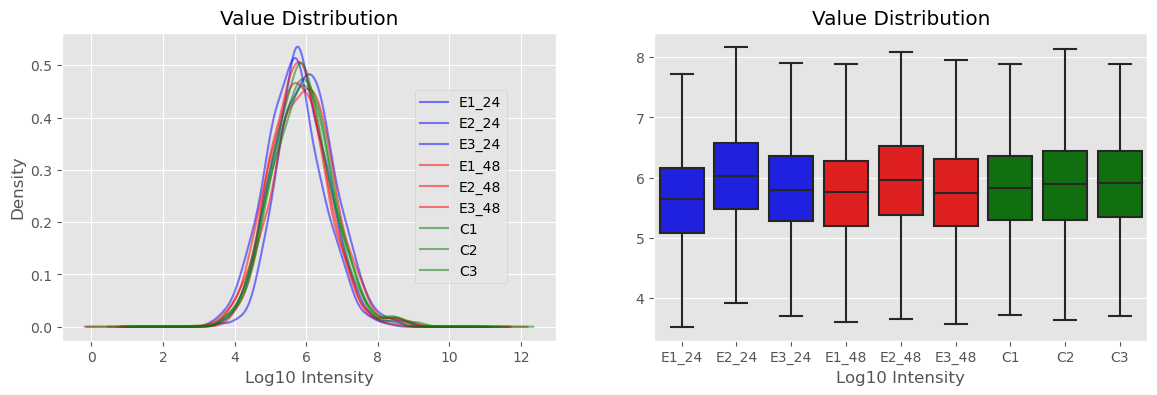

In [65]:
plt.style.use('ggplot')
fig,axes=plt.subplots(ncols=2,nrows=1,figsize=(14,4))

np.log10(selection.replace(0,np.nan)).plot(
    kind='kde', color=palette, alpha=0.5,ax=axes[0])
axes[0].legend(loc='center left', bbox_to_anchor=(0.7, 0.5))
axes[0].set_title('Value Distribution')
axes[0].set_xlabel('Log10 Intensity')

sns.boxplot(data =np.log10(selection.replace(0,np.nan)),
            showfliers=False,palette=palette,ax=axes[1])
plt.title('Value Distribution')
plt.xlabel('Log10 Intensity')
plt.savefig(os.path.join(TXT_PATH, 'value_distribution.png'))
plt.show()

In [66]:
selection.head()

,E1_24,E2_24,E3_24,E1_48,E2_48,E3_48,C1,C2,C3
0,60028000.0,90019000.0,17170000.0,56801000.0,31066000.0,1642500.0,44836.0,0.0,0.0
72,61996.0,284160.0,60131.0,45297.0,177640.0,32438.0,305770.0,130720.0,82699.0
74,98221.0,147320.0,296710.0,133530.0,290080.0,161310.0,521370.0,350320.0,129860.0
76,11631.0,46225.0,20071.0,25020.0,42658.0,5042.1,28655.0,31074.0,25978.0
77,171920.0,263540.0,141310.0,253930.0,12193.0,0.0,0.0,0.0,0.0


## Missing Data

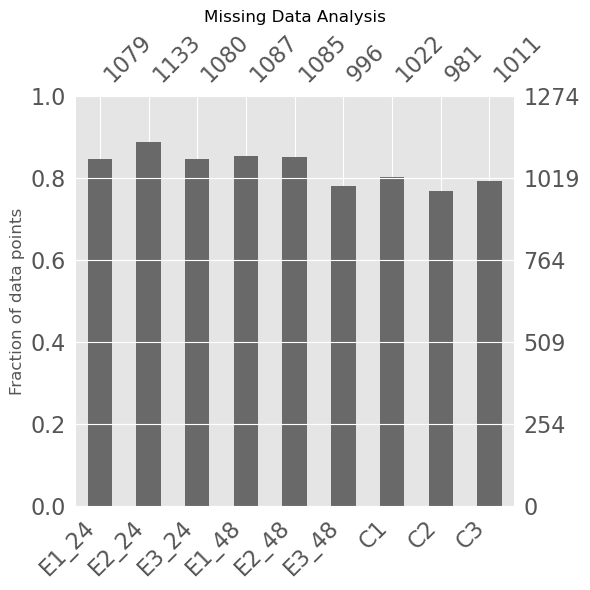

In [67]:
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
#visualization of missing data
ax=msno.bar(selection.replace(0,np.nan),figsize=(6, 6))
plt.title('Missing Data Analysis',size=12)
ax.set_ylabel('Fraction of data points',size=12)
plt.tight_layout()
plt.savefig('missing.png')
plt.show()

{'b': '24h', 'r': '48h', 'g': 'Control'}


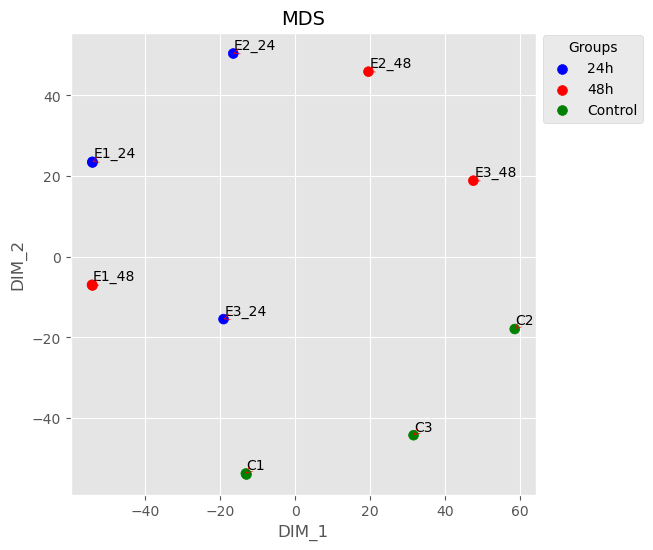

In [68]:
plt.style.use('ggplot')
np.random.seed=1976
fig,ax = plt.subplots(figsize=(6,6), ncols=1, nrows=1)
PTUT.make_mds(np.log10(selection+1).dropna(),
              palette,ax,color_dictionary=color_dictionary,top=1200)
plt.savefig('MDS.png')
plt.show()



## Proteins Found only in bait

In [69]:
bait_cols=[n.replace(tag,'').strip() for n in bait_cols]
control_cols=[n.replace(tag,'').strip() for n in control_cols]

bait_nan = selection[bait_cols].replace(0,np.nan).isna().sum(axis=1)
control_nan  = selection[control_cols].replace(0,np.nan).isna().sum(axis=1)
only_bait = selection[(bait_nan==0) & (control_nan==3)]
only_control = selection[(bait_nan==3) & (control_nan<3)]
print(' Found only in Bait:',only_bait.shape[0],'\n',
      'Found only in Control:',only_control.shape[0])

 Found only in Bait: 23 
 Found only in Control: 79


In [70]:
#selection[['Bait_1','Bait_2','Bait_3']] = selection[['Bait_1','Bait_2','Bait_3']].replace(0,np.nan)
#selection[['Bait_1','Bait_2','Bait_3']] = selection[['Bait_1','Bait_2','Bait_3']]/selection[['Bait_1','Bait_2','Bait_3']].median()
only_bait['mean']=selection[bait_cols].replace(0,np.nan).mean(axis=1)
to_look = only_bait.sort_values('mean', ascending=False).index.values
temp = df.loc[to_look]
temp=temp.join(selection[bait_cols])
temp['mean']=temp[bait_cols].replace(0,np.nan).mean(axis=1,skipna=True)
temp['exp_rank']=temp['mean'].rank(ascending=False)

temp[['Gene_id','mean']+bait_cols+['Score','exp_rank']].head(20)

,Gene_id,mean,E1_24,E2_24,E3_24,E1_48,E2_48,E3_48,Score,exp_rank
1140,sp|Q80UU9|PGRC2_MOUSE,2.325045e+07,12916000.0,49517000.0,10160000.0,16911000.0,44061000.0,5937700.0,125.470,1.0
482,sp|P49817|CAV1_MOUSE,1.232903e+07,6015700.0,23340000.0,2271900.0,13328000.0,27723000.0,1295600.0,24.682,2.0
612,sp|P63024|VAMP3_MOUSE,1.112018e+07,2605300.0,22097000.0,3207800.0,12741000.0,24207000.0,1863000.0,110.420,3.0
1709,sp|Q9CQW1|YKT6_MOUSE,9.497417e+06,3313900.0,18795000.0,2578400.0,10844000.0,19172000.0,2281200.0,38.910,4.0
1711,sp|Q9CQW9|IFM3_MOUSE,8.534028e+06,4405000.0,13901000.0,5483500.0,13652000.0,13214000.0,548670.0,10.806,5.0
1319,tr|A0A0J9YTY0|A0A0J9YTY0_MOUSE,4.908087e+06,1793900.0,9902200.0,1302300.0,4349200.0,11343000.0,757920.0,127.570,6.0
1379,tr|A0A0R4J1G9|A0A0R4J1G9_MOUSE,3.377193e+06,1734200.0,6784900.0,1624700.0,3975400.0,5764700.0,379260.0,36.618,7.0
144,sp|O09044|SNP23_MOUSE,2.228165e+06,1408800.0,5738900.0,892600.0,2043000.0,3134500.0,151190.0,55.636,8.0
338,sp|P18572|BASI_MOUSE,2.076612e+06,766750.0,3800000.0,240020.0,2218100.0,5159900.0,274900.0,12.413,9.0
2187,tr|F7DBB3|F7DBB3_MOUSE,1.844267e+06,2770700.0,2403400.0,875670.0,3790300.0,1077500.0,148030.0,52.031,10.0


In [71]:
temp.to_csv('only_bait.csv')

In [72]:
#print(selection.shape)
#selection=selection[(bait_nan==0)]
#print(selection.shape)

## Differential Abundance

### ProtRank indata

In [73]:
indata_prank=selection.join(df[['Gene_id']],how='left')
indata_prank.set_index('Gene_id',drop=True,inplace=True)
indata_prank=indata_prank
indata_prank.to_csv(os.path.join(TXT_PATH, 'indata_ProtRank.csv'))
indata_prank.head()

,E1_24,E2_24,E3_24,E1_48,E2_48,E3_48,C1,C2,C3
Gene_id,,,,,,,,,
BACE1-BirA,60028000.0,90019000.0,17170000.0,56801000.0,31066000.0,1642500.0,44836.0,0.0,0.0
tr|E9PXY1|E9PXY1_MOUSE,61996.0,284160.0,60131.0,45297.0,177640.0,32438.0,305770.0,130720.0,82699.0
sp|A2A6A1|GPTC8_MOUSE,98221.0,147320.0,296710.0,133530.0,290080.0,161310.0,521370.0,350320.0,129860.0
tr|F6VYE2|F6VYE2_MOUSE,11631.0,46225.0,20071.0,25020.0,42658.0,5042.1,28655.0,31074.0,25978.0
tr|F6Y3V0|F6Y3V0_MOUSE,171920.0,263540.0,141310.0,253930.0,12193.0,0.0,0.0,0.0,0.0


In [74]:
indata_prank.columns

Index(['E1_24', 'E2_24', 'E3_24', 'E1_48', 'E2_48', 'E3_48', 'C1', 'C2', 'C3'], dtype='object')

### ProtRank Test

In [75]:
what_to_compare = [[
    ['C1', 'E1_24'], 
    ['C2', 'E2_24' ], 
    ['C3', 'E3_24' ],                  
                   ]]
ProtRank.data_stats(indata_prank, what_to_compare = what_to_compare)
description = 'bait_vs_control_24'
significant_proteins = ProtRank.rank_proteins(
    indata_prank+indata_prank[indata_prank>0].min(), 
    what_to_compare, description,
    path_to=TXT_PATH,num_bootstrap_realizations=100)


input data contain results for 1274 proteins and 9 different conditions
list of measured conditions: E1_24, E2_24, E3_24, E1_48, E2_48, E3_48, C1, C2, C3
in the data, 17.4% of all counts are zeros

basic statistics for the subset of the data corresponding to the provided comparisons:
6 comparisons provided: [[['C1', 'E1_24'], ['C2', 'E2_24'], ['C3', 'E3_24']]]
after ignoring 3 rows with only zero counts, 1271 rows remain
in the analyzed data, 17.3% of all counts are zeros
median count is 6.96e+05 (computed over non-zero entries only)
ratio between the largest and the smallest non-zero count is 1.70e+06
ratio between the 90th and the 10th percentile non-zero count is 1.24e+02
statistics of irregular missing values:
  in total, there are 788 comparisons involving a zero and a non-zero value (20.7% of all)
  out of 3813 comparisons, 174 involve a zero value and a non-zero exceeding 1.0 * median (4.6% of all)
  (the smaller the fraction, the smaller the problem with irregular zeros in the

In [76]:
what_to_compare = [[
    ['C1', 'E1_48'], 
    ['C2', 'E2_48' ], 
    ['C3', 'E3_48' ], 
                   ]]
ProtRank.data_stats(indata_prank, what_to_compare = what_to_compare)
description = 'bait_vs_control_48'
significant_proteins = ProtRank.rank_proteins(
    indata_prank+indata_prank[indata_prank>0].min(), 
    what_to_compare, description,
    path_to=TXT_PATH,num_bootstrap_realizations=100)


input data contain results for 1274 proteins and 9 different conditions
list of measured conditions: E1_24, E2_24, E3_24, E1_48, E2_48, E3_48, C1, C2, C3
in the data, 17.4% of all counts are zeros

basic statistics for the subset of the data corresponding to the provided comparisons:
6 comparisons provided: [[['C1', 'E1_48'], ['C2', 'E2_48'], ['C3', 'E3_48']]]
after ignoring 40 rows with only zero counts, 1234 rows remain
in the analyzed data, 16.5% of all counts are zeros
median count is 7.03e+05 (computed over non-zero entries only)
ratio between the largest and the smallest non-zero count is 2.08e+06
ratio between the 90th and the 10th percentile non-zero count is 1.30e+02
statistics of irregular missing values:
  in total, there are 666 comparisons involving a zero and a non-zero value (18.0% of all)
  out of 3702 comparisons, 122 involve a zero value and a non-zero exceeding 1.0 * median (3.3% of all)
  (the smaller the fraction, the smaller the problem with irregular zeros in th

In [77]:
res_24 = pd.read_csv(os.path.join(TXT_PATH,'prs-bait_vs_control_24.dat'),
                   sep='\t', comment='#', index_col=[0],
                   names=['Gene_id','rank','FDR','sign'])
res_24['log_FDR']=-np.log10(res_24['FDR']+0.001)
res_24['log_rank']=np.log10(res_24['rank'])
res_24['srank']=[n*1 if a=='+' else n*-1 for n,a in zip(res_24['rank'],res_24['sign'])]
res_24=res_24.merge(df,left_on='Gene_id',right_on='Gene_id',how='left')
#temp_1=temp_1.merge(aboundance_df,left_on='Gene_id',right_on='Gene ID',how='left')
res_24['exp_rank']=res_24['rank'].rank(ascending=False)
res_24.to_csv('res_24.csv')

In [78]:
res_48 = pd.read_csv(os.path.join(TXT_PATH,'prs-bait_vs_control_48.dat'),
                   sep='\t', comment='#', index_col=[0],
                   names=['Gene_id','rank','FDR','sign'])
res_48['log_FDR']=-np.log10(res_48['FDR']+0.001)
res_48['log_rank']=np.log10(res_48['rank'])
res_48['srank']=[n*1 if a=='+' else n*-1 for n,a in zip(res_48['rank'],res_48['sign'])]
res_48=res_48.merge(df,left_on='Gene_id',right_on='Gene_id',how='left')
#temp_1=temp_1.merge(aboundance_df,left_on='Gene_id',right_on='Gene ID',how='left')
res_48['exp_rank']=res_48['rank'].rank(ascending=False)
res_48.to_csv('res_48.csv')

In [79]:

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
cm2inch(19, 9.5)

(7.480314960629921, 3.7401574803149606)

In [80]:
#ids = temp_1[(temp_1['srank']>40) & (temp_1['FDR']<0.01)]
#ids

In [81]:
#PTUT.make_vulcano??

## Fig1 Static

12
12
no selection


No handles with labels found to put in legend.


12
12
no selection


No handles with labels found to put in legend.


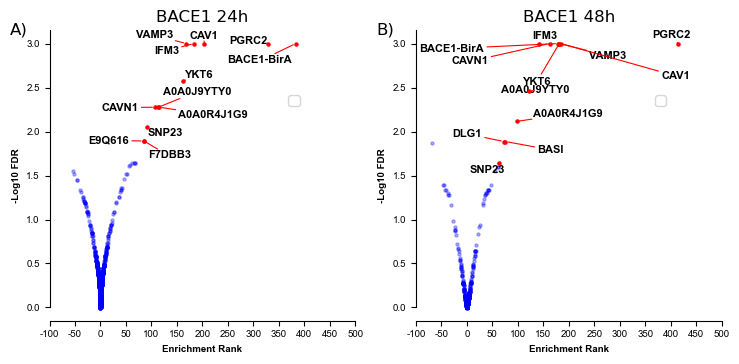

In [82]:
#ax.spines['left'].set_bounds(ymin+small_add, ymax)

#xmin, xmax = ax.get_xlim()
#ax.set_xlim(xmin,xmax)

#ax.spines['bottom'].set_bounds(xmin+0.5, xmax)
fontProperties = {'family':'Arial',
    'weight' : 'normal', 'size' : 7}
fontProperties_names = {'family':'Arial',
    'weight' : 'bold', 'size' : 7}

plt.style.use('fivethirtyeight')
plt.style.use('default')



fig, axes=plt.subplots(figsize=(7.48,3.74), 
                     ncols=2, nrows=1)

ids = res_24.sort_values('srank',ascending=False).head(12)
_ids = ids.index.values
_names = [n.split('|')[-1].replace('_MOUSE','') for n in ids['Gene_id'].values]
print(len(_ids))
print(len(_names))
ax=axes[0]
PTUT.make_vulcano(res_24, ax, x='srank', y='log_FDR', 
             annot_index=_ids,
             annot_names = _names,
             title='',
             #fc_limit=70,
             fc_col='log_rank',
                  alpha_main=0.3,
             point_size_selection=5,
             point_size_all=5,
            text_size=8,
                  fontdict=fontProperties_names,
                  expand_points=(6, 6),
                expand_text=(1.5, 1.5)
            )

ax.set_title('BACE1 24h')
ax.set_xlabel('Enrichment Rank',fontdict=fontProperties_names)
ax.set_ylabel('-Log10 FDR',fontdict=fontProperties_names)
#ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9),
#          title='Legend')
#ax.yaxis.label.set_size(18)
#ax.xaxis.label.set_size(18)
ax.title.set_size(12)
ax.tick_params(axis='both', which='major', labelsize=7)





temp_xticks=[int(n) for n in np.arange(-100,550,50)]
ax.set_xticks(temp_xticks)
ax.set_xticklabels(temp_xticks, fontProperties)
ax.set_yticklabels(ax.get_yticks(), fontProperties)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
xmin, xmax = ax.get_xlim()
ax.spines['bottom'].set_bounds(-100, 500)
ymin, ymax = ax.get_ylim()
ax.spines['left'].set_bounds(0, ymax)

ax.text(-0.1, 1, 'A)', horizontalalignment='center', 
               verticalalignment='center',
               transform=ax.transAxes,fontsize=12)


ax=axes[1]
ids = res_48.sort_values('srank',ascending=False).head(12)
_ids = ids.index.values
_names = [n.split('|')[-1].replace('_MOUSE','') for n in ids['Gene_id'].values]
print(len(_ids))
print(len(_names))

PTUT.make_vulcano(res_48, ax, x='srank', y='log_FDR', 
             annot_index=_ids,
             annot_names = _names,
             title='',
             #fc_limit=70,
             fc_col='log_rank',
                  alpha_main=0.3,
             point_size_selection=5,
             point_size_all=5,
            text_size=8,
                  fontdict=fontProperties_names,
                  expand_points=(5, 5),
                expand_text=(2, 2)
            )

ax.set_title('BACE1 48h')
ax.set_xlabel('Enrichment Rank',fontdict=fontProperties_names)
ax.set_ylabel('-Log10 FDR',fontdict=fontProperties_names)
#ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9),
#          title='Legend')
#ax.yaxis.label.set_size(18)
#ax.xaxis.label.set_size(18)
ax.title.set_size(12)
ax.tick_params(axis='both', which='major', labelsize=7)




temp_xticks=[int(n) for n in np.arange(-100,550,50)]
ax.set_xticks(temp_xticks)
ax.set_xticklabels(temp_xticks, fontProperties)
ax.set_yticklabels(ax.get_yticks(), fontProperties)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
xmin, xmax = ax.get_xlim()
ax.spines['bottom'].set_bounds(-100, 500)
ymin, ymax = ax.get_ylim()
ax.spines['left'].set_bounds(0, ymax)

ax.text(-0.1, 1, 'B)', horizontalalignment='center', 
               verticalalignment='center',
               transform=ax.transAxes,fontsize=12)






plt.tight_layout()
plt.savefig('Fig1.svg')

plt.savefig('Fig1.png')
plt.show()

#w 190 mm 
#h 95 mm 
#font 7pt and Arial
#x/y axes annotation Arial 7pt bold
#top 10

10 9 9


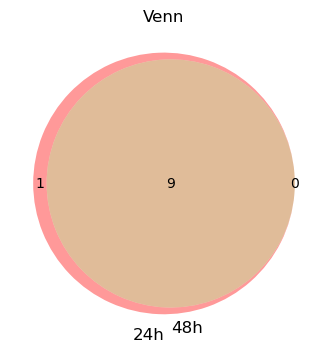

In [83]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
def make_venn(ax):
    #fig,ax = plt.subplots()
    df_24 = res_24[(res_24['FDR']<0.01) & (res_24['sign']=='+')]['Gene_id']
    df_48 = res_48[(res_48['FDR']<0.01) & (res_48['sign']=='+')]['Gene_id']
    common = len(set(df_24)&set(df_48))
    print(df_24.shape[0],df_48.shape[0],common)
    venn2(subsets = (df_24.shape[0]-common, 
                     df_48.shape[0]-common, 
                     common ), 
          set_labels = ('24h', '48h'), ax=ax)

fig,ax=plt.subplots(figsize=(4,4))
make_venn(ax)
plt.title('Venn')
fig.savefig('venn.png')
plt.show()

## Fig1 Interactive

In [84]:
import plotly.express as px
from plotly.subplots import make_subplots



fig1 = px.scatter(res_24, x='srank', y='log_FDR', #color="log_FDR",
                 #title='PIGA interacting partners',
                 width=800, height=600,
                 hover_name="Gene_id", hover_data=["desc"],
                 #color_continuous_scale='Bluered',#px.colors.sequential.Viridis,
                )


fig2 = px.scatter(res_48, x='srank', y='log_FDR', #color="log_FDR",
                 #title='PIGA interacting partners',
                 width=800, height=600,
                 hover_name="Gene_id", hover_data=["desc"],
                 #color_continuous_scale='Bluered',#px.colors.sequential.Viridis,
                )



trace1 = fig1['data'][0]
trace2 = fig2['data'][0]

fig = make_subplots(rows=1, cols=2, shared_xaxes=False,shared_yaxes=False)
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)

fig.layout["xaxis"].title.text = "Experiment Rank"
fig.layout["xaxis2"].title.text = "Experiment Rank"
fig.layout["yaxis"].title.text = "Log10 FDR"
fig.layout["yaxis2"].title.text = "Log10 FDR"
fig.update_layout(title_text='BACE1 Interacting Partners')
#fig.show()
fig.write_html("BACE1.html")

In [85]:
from IPython.display import IFrame
IFrame("BACE1.html", width=1000, height=600)

In [86]:
#from IPython.display import FileLink, FileLinks
#FileLink('Dataset.csv')

In [87]:
!jupyter nbconvert --to html_toc analysis_def.ipynb

[NbConvertApp] Converting notebook analysis_def.ipynb to html_toc
[NbConvertApp] Support files will be in analysis_def_files/
[NbConvertApp] Making directory analysis_def_files
[NbConvertApp] Making directory analysis_def_files
[NbConvertApp] Making directory analysis_def_files
[NbConvertApp] Making directory analysis_def_files
[NbConvertApp] Making directory analysis_def_files
[NbConvertApp] Writing 388897 bytes to analysis_def.html
